In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import re

from reviews.preprocess import preprocess
from reviews.config import processed_data_dir

# Read Dataset

In [5]:
# load data
prod_df = pd.read_json(processed_data_dir / "meta_digital_cameras.json.gz")
review_df = pd.read_json(processed_data_dir / "reviews_digital_cameras.json.gz")

In [6]:
# merge data (inner mode)
data_df = pd.merge(left=prod_df, right=review_df, on="asin")
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87205 entries, 0 to 87204
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   category     87205 non-null  object        
 1   description  87205 non-null  object        
 2   title        87205 non-null  object        
 3   brand        87205 non-null  object        
 4   main_cat     87205 non-null  object        
 5   date         87205 non-null  object        
 6   price        87205 non-null  object        
 7   asin         87205 non-null  object        
 8   overall      87205 non-null  int64         
 9   vote         87205 non-null  int64         
 10  text         87205 non-null  object        
 11  summary      87205 non-null  object        
 12  timestamp    87205 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 6.0+ MB


In [7]:
# head of merge data
data_df.head(10)

,category,description,title,brand,main_cat,date,price,asin,overall,vote,text,summary,timestamp
0,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,47,"I bought the Smile to have a handy, inexpensiv...",Not the best choice,2000-02-10
1,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,24,It is absolutely useless. The pictures are gr...,This camera is HORRIBLE!,2000-10-12
2,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,4,73,Bought one from Amazon and begun immediately t...,What do you need?,2000-08-23
3,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,28,"I'm on a small budget this summer, so I bought...","Worse than I thought, but at that price...",2000-06-06
4,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,3,109,My first experiences with AGFA cameras were in...,Not bad for the money,2000-05-25
5,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,5,I bought two of these for my kids and they are...,Just awful; avoid at all costs,2001-04-09
6,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,0,It's a nice little TOY. That's all it is. It...,Sold it for $40...I think I ripped the guy off.,2001-01-07
7,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,4,3,I really like mine. It takes good pictures. It...,Kodak 240,2000-10-11
8,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,5,4,This is the best camera I have seen for the pr...,"Great Camera, Great Features, Easy Use",2000-09-22
9,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,4,10,"I have been in photography for about 15 years,...",Great Camera for the price!,2000-08-10


In [8]:
rgx = re.compile(r"\'(.*?)\'")


def transform_categories(text):
    text = rgx.sub(r"\g<1>", text.replace("[", "").replace("]", ""))
    # text = text.replace("Electronics, Camera & Photo, Digital Cameras", "")
    text = " ,".join([x for x in text.split(",") if x])
    return text


# transform category and description from list of string to a string
data_df["category"] = (
    data_df["category"].astype("string").transform(transform_categories)
)
data_df["description"] = (
    data_df["description"].astype("string").transform(transform_categories)
)

# convert price to float
# remove invalid prices (html broken)
# set to zero all invalid prices
data_df["price"].loc[data_df["price"].astype("string").str.len() > 20] = "-1"
data_df["price"].loc[data_df["price"].astype("string").str.len() == 0] = "-1"
data_df["price"] = (
    data_df["price"]
    .astype("string")
    .str.replace("$", "")
    .str.replace(",", "")
    .astype("float")
)  # non serve proprio!

# transform to string
data_df["title"] = data_df["title"].astype("string")
data_df["date"] = data_df["date"].astype("string")  # non serve proprio!
data_df["asin"] = data_df["asin"].astype("string")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")

# transform to category
data_df["category"] = data_df["category"].astype("category")  # non serve proprio!
data_df["brand"] = data_df["brand"].astype("category")
data_df["main_cat"] = data_df["main_cat"].astype("category")  # non serve proprio!

c:\Users\mirco\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\mirco\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\mirco\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character r

In [9]:
# print(data_df['overall'].isnull().values.any())
# print(data_df['overall'].isna().values.any())

# count empty attributes

empty_category = data_df.loc[data_df["category"] == ""]
empty_brand = data_df.loc[data_df["brand"] == ""]
empty_main_cat = data_df.loc[data_df["main_cat"] == ""]
empty_description = data_df.loc[data_df["description"].str.len() == 0]
empty_title = data_df.loc[data_df["title"].str.len() == 0]
empty_date = data_df.loc[data_df["date"].str.len() == 0]
empty_price = data_df.loc[data_df["price"] == -1]
empty_asin = data_df.loc[data_df["asin"].str.len() == 0]

empty_overall = data_df.loc[data_df["overall"] == ""]
empty_vote = data_df.loc[data_df["vote"] == ""]
empty_timestamp = data_df.loc[data_df["timestamp"] == ""]
empty_text = data_df.loc[data_df["text"].str.len() == 0]
empty_summary = data_df.loc[data_df["summary"].str.len() == 0]
empty_asin = data_df.loc[data_df["asin"].str.len() == 0]

counts_empty_fields = [
    len(empty_category),
    len(empty_description),
    len(empty_title),
    len(empty_brand),
    len(empty_main_cat),
    len(empty_date),
    len(empty_price),
    len(empty_asin),
    len(empty_overall),
    len(empty_vote),
    len(empty_text),
    len(empty_summary),
    len(empty_timestamp),
]

print(dict(zip(list(data_df.columns), counts_empty_fields)))

{'category': 0, 'description': 1671, 'title': 0, 'brand': 5, 'main_cat': 28, 'date': 578, 'price': 37684, 'asin': 0, 'overall': 0, 'vote': 0, 'text': 0, 'summary': 0, 'timestamp': 0}


In [10]:
# remove useless attributes
data_df.drop("category", axis=1, inplace=True)
data_df.drop("main_cat", axis=1, inplace=True)
data_df.drop("date", axis=1, inplace=True)
data_df.drop("price", axis=1, inplace=True)

In [11]:
# remove duplicates
data_df.drop_duplicates(inplace=True)

# remove all rows for empty (brand, main_cat, date)
data_df = data_df.loc[data_df["brand"] != ""]
data_df = data_df.loc[data_df["text"] != ""]
data_df = data_df.loc[data_df["description"] != ""]

In [12]:
# count empty attributes

empty_brand = data_df.loc[data_df["brand"] == ""]
empty_description = data_df.loc[data_df["description"].str.len() == 0]
empty_title = data_df.loc[data_df["title"].str.len() == 0]
empty_asin = data_df.loc[data_df["asin"].str.len() == 0]

empty_overall = data_df.loc[data_df["overall"] == ""]
empty_vote = data_df.loc[data_df["vote"] == ""]
empty_timestamp = data_df.loc[data_df["timestamp"] == ""]
empty_text = data_df.loc[data_df["text"].str.len() == 0]
empty_summary = data_df.loc[data_df["summary"].str.len() == 0]
empty_asin = data_df.loc[data_df["asin"].str.len() == 0]

counts_empty_fields = [
    len(empty_description),
    len(empty_title),
    len(empty_brand),
    len(empty_asin),
    len(empty_overall),
    len(empty_vote),
    len(empty_text),
    len(empty_summary),
    len(empty_timestamp),
]

print(dict(zip(list(data_df.columns), counts_empty_fields)))

{'description': 0, 'title': 0, 'brand': 0, 'asin': 0, 'overall': 0, 'vote': 0, 'text': 0, 'summary': 0, 'timestamp': 0}


In [13]:
# remove possible html tags
from reviews.preprocess import strip_html

data_df["description"] = data_df["description"].astype("string").apply(strip_html)
data_df["title"] = data_df["title"].astype("string").apply(strip_html)
data_df["text"] = data_df["text"].astype("string").apply(strip_html)
data_df["summary"] = data_df["summary"].astype("string").apply(strip_html)

MemoryError: 

In [ ]:
data_df.head(20)

,description,title,brand,asin,overall,vote,text,summary,timestamp
0,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,1,47,"I bought the Smile to have a handy, inexpensiv...",Not the best choice,2000-02-10
1,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,1,24,It is absolutely useless. The pictures are gr...,This camera is HORRIBLE!,2000-10-12
2,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,4,73,Bought one from Amazon and begun immediately t...,What do you need?,2000-08-23
3,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,1,28,"I'm on a small budget this summer, so I bought...","Worse than I thought, but at that price...",2000-06-06
4,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,3,109,My first experiences with AGFA cameras were in...,Not bad for the money,2000-05-25
5,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,1,5,I bought two of these for my kids and they are...,Just awful; avoid at all costs,2001-04-09
6,"Digital camera 640x480 resolution , 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,B00000JBIA,1,0,It's a nice little TOY. That's all it is. It...,Sold it for $40...I think I ripped the guy off.,2001-01-07
7,Boosts productivity while improving your image...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,B00000JDEL,4,3,I really like mine. It takes good pictures. It...,Kodak 240,2000-10-11
8,Boosts productivity while improving your image...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,B00000JDEL,5,4,This is the best camera I have seen for the pr...,"Great Camera, Great Features, Easy Use",2000-09-22
9,Boosts productivity while improving your image...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,B00000JDEL,4,10,"I have been in photography for about 15 years,...",Great Camera for the price!,2000-08-10


In [1]:
# number of reviews per product(ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(40, 7))
plt.xticks(rotation=45)
sns.barplot(data[0], data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print(z["asin"].mean())

NameError: name 'pd' is not defined

# Overall

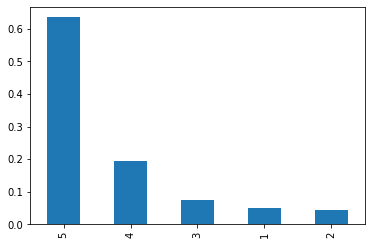

In [ ]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(kind="bar")

pass

In [ ]:
# min and max of overall mean
print((data_df.groupby("asin")["overall"].mean()).min())
print((data_df.groupby("asin")["overall"].mean()).max())

# mean of overall
print(data_df.groupby("asin")["overall"].mean())

1.6
5.0
asin
B00000JBIA    1.714286
B00000JDEL    4.400000
B00000JFIF    4.833333
B00000JYLO    3.928571
B00000JYWQ    4.111111
                ...   
B01GKNUGHC    4.666667
B01H65ESKY    4.375000
B01HDQBSR2    4.333333
B01HH8H2WQ    4.777778
B01HHR572O    3.833333
Name: overall, Length: 2099, dtype: float64


# Vote

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


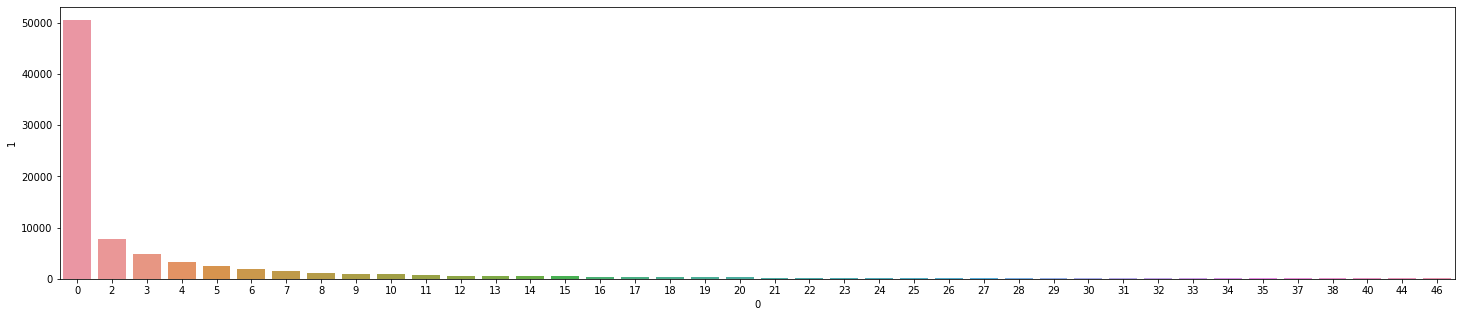

In [ ]:
# count of helpful vote number
from collections import Counter
from locale import normalize
import seaborn as sns
from matplotlib import pyplot as plt

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(40))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

In [ ]:
# min and max of vote mean
print((data_df.groupby("asin")["vote"].mean()).min())
print((data_df.groupby("asin")["vote"].mean()).max())

# mean of vote
print(data_df.groupby("asin")["vote"].mean())

0.0
319.73333333333335
asin
B00000JBIA    40.857143
B00000JDEL     8.600000
B00000JFIF    32.166667
B00000JYLO    22.857143
B00000JYWQ    37.500000
                ...    
B01GKNUGHC     0.222222
B01H65ESKY     1.625000
B01HDQBSR2     1.888889
B01HH8H2WQ     1.888889
B01HHR572O    11.000000
Name: vote, Length: 2099, dtype: float64


# Brand Reviewed

### Most Reviewed Brand

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


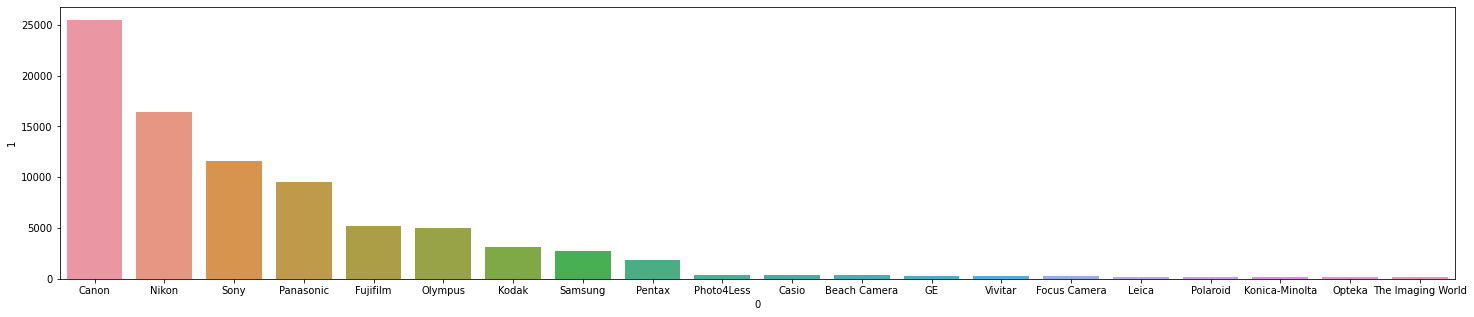

In [ ]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

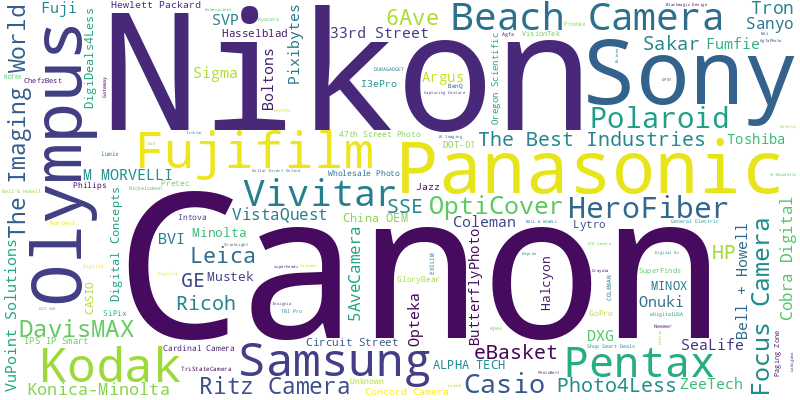

In [ ]:
c = Counter(list(prod_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Mean Overall per Brand

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


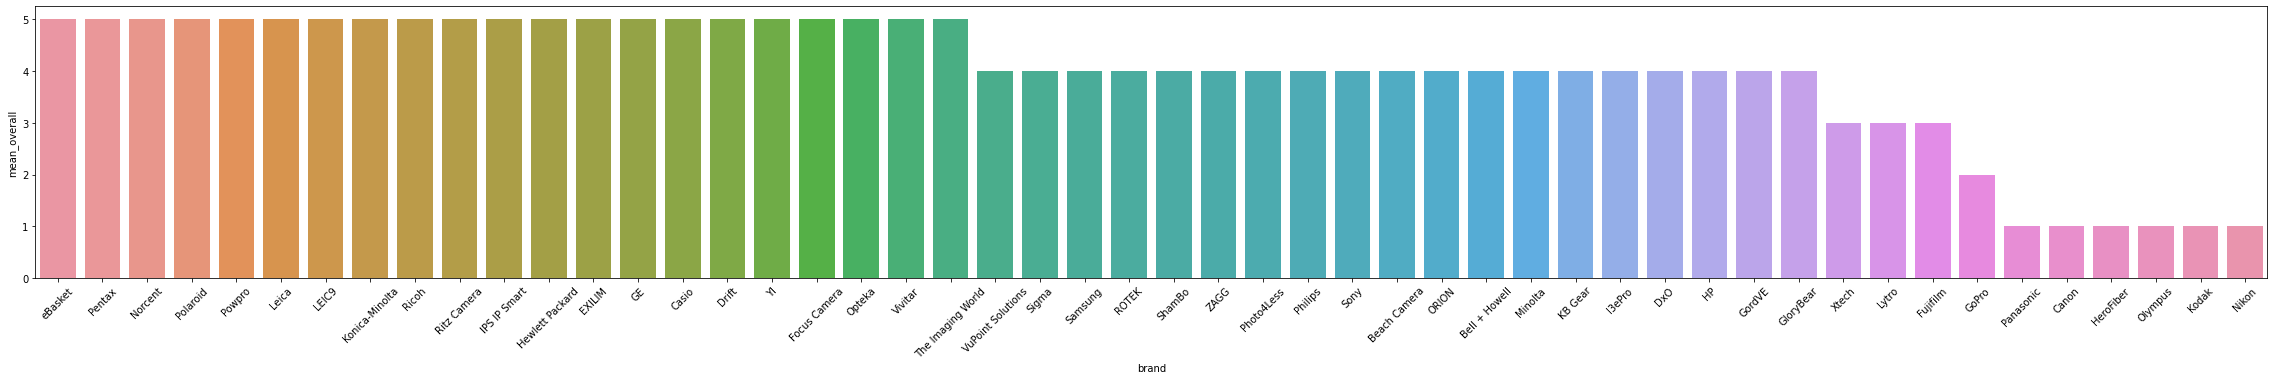

In [ ]:
# mean valuation for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(50))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"overall": [np.mean]})
df.columns = ["mean_overall"]
df.reset_index(inplace=True)

_, ax = plt.subplots(figsize=(40, 5))
plt.xticks(rotation=45)
sns.barplot(
    df["brand"],
    df["mean_overall"],
    ax=ax,
    order=df.sort_values(by="mean_overall", ascending=False).brand,
)

pass

### Mean Vote per Brand

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


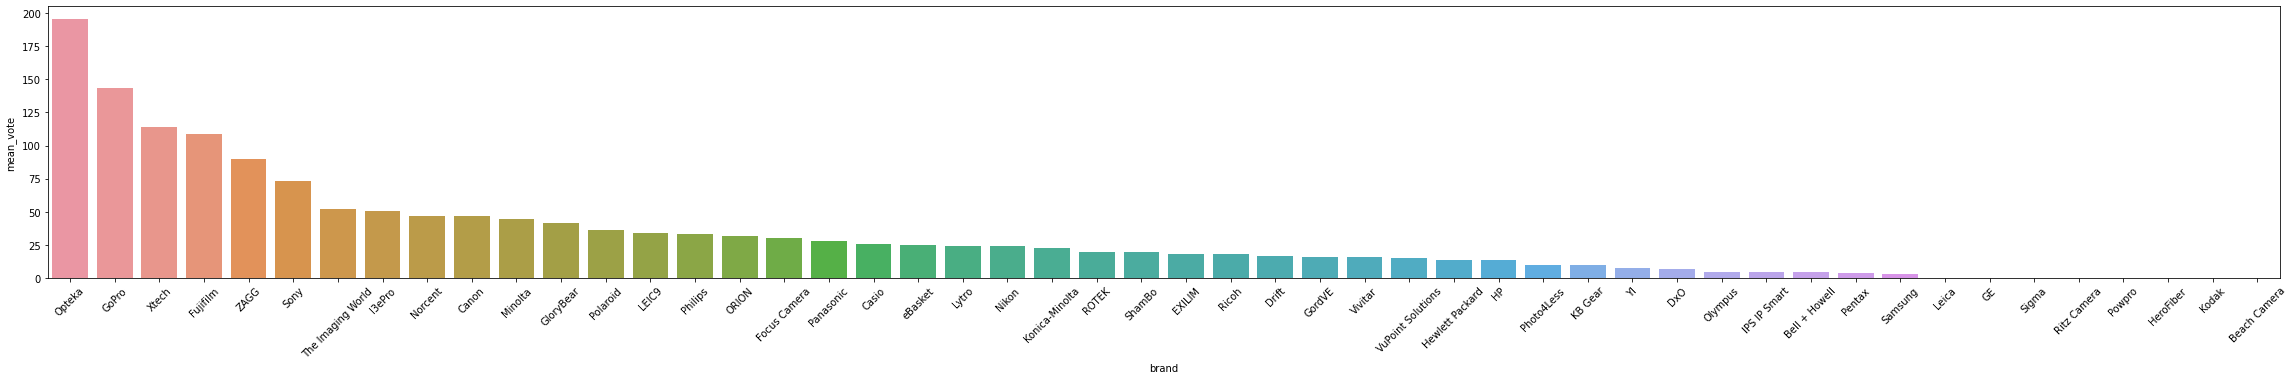

In [ ]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(50))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

_, ax = plt.subplots(figsize=(40, 5))
plt.xticks(rotation=45)
sns.barplot(
    df["brand"],
    df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)

pass

# Review Time Series

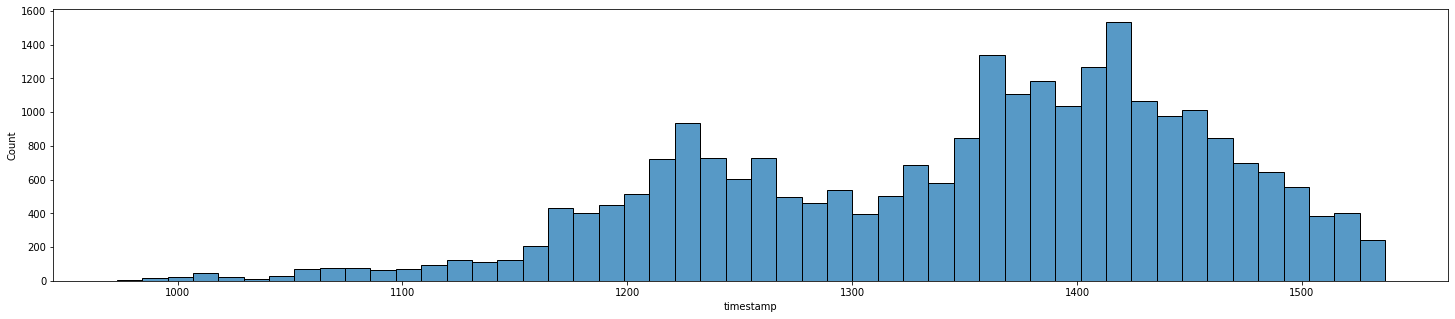

In [ ]:
# numero di reviews nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
sns.histplot(data_df[data_df["brand"] == "Canon"]["timestamp"], ax=ax)

pass

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


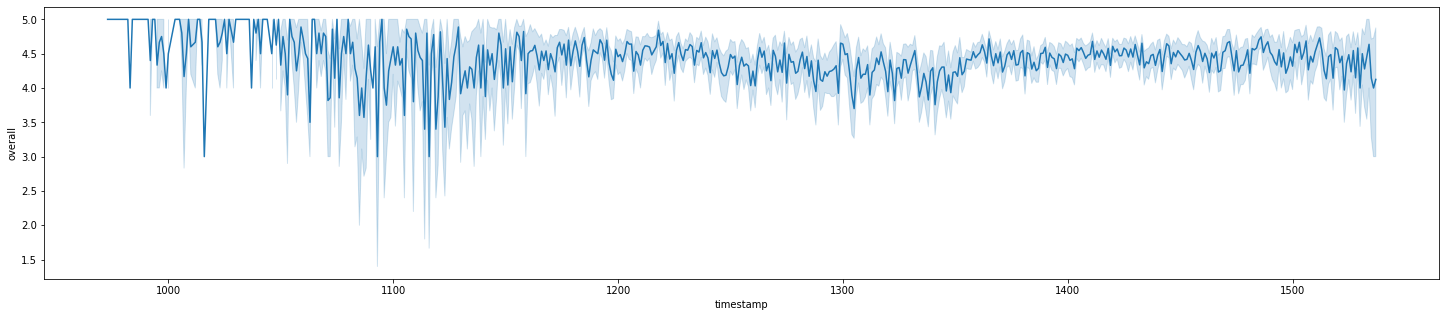

In [ ]:
# overall nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
x = data_df[data_df["brand"] == "Canon"]["overall"]
y = data_df[data_df["brand"] == "Canon"]["timestamp"]
sns.lineplot(y, x, ax=ax)

pass

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


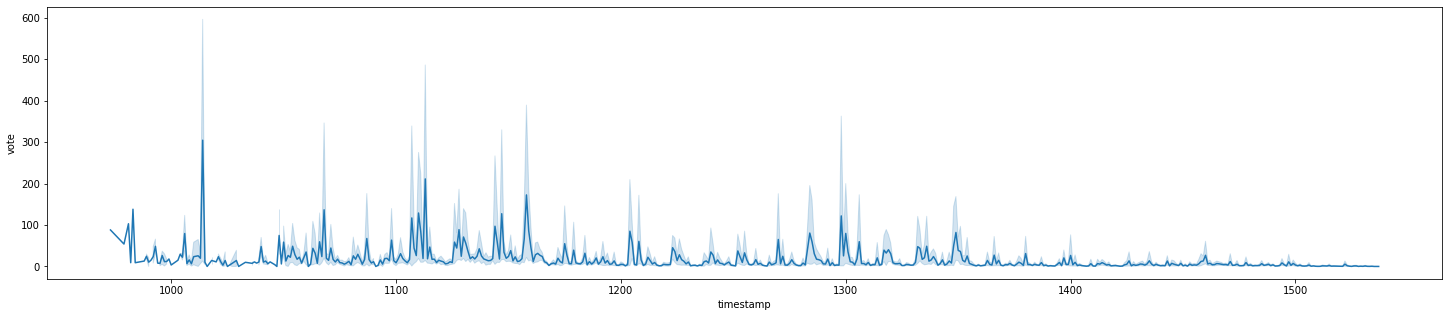

In [ ]:
# vote nel tempo del brand X

_, ax = plt.subplots(figsize=(25, 5))
x = data_df[data_df["brand"] == "Canon"]["vote"]
y = data_df[data_df["brand"] == "Canon"]["timestamp"]
sns.lineplot(y, x, ax=ax)

pass

# Review Text and Summary

### Review Language Detction

In [ ]:
# keep eng only reviews

from reviews.lang_identification import LanguageIdentification

!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

lang_detector = LanguageIdentification()

for x in data_df["summary"].tolist():
    data_df["lang"] = lang_detector.predict_lang(x)

--2022-07-19 12:25:32--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125,18M  9,25MB/s    in 14s     

2022-07-19 12:25:47 (8,92 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [ ]:
data_df["lang"].value_counts()

ml    85531
Name: lang, dtype: int64

### Summary

In [ ]:
data_df["summary"].head(10)

0                                Not the best choice
1                           This camera is HORRIBLE!
2                                  What do you need?
3         Worse than I thought, but at that price...
4                              Not bad for the money
5                     Just awful; avoid at all costs
6    Sold it for $40...I think I ripped the guy off.
7                                          Kodak 240
8             Great Camera, Great Features, Easy Use
9                        Great Camera for the price!
Name: summary, dtype: object

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


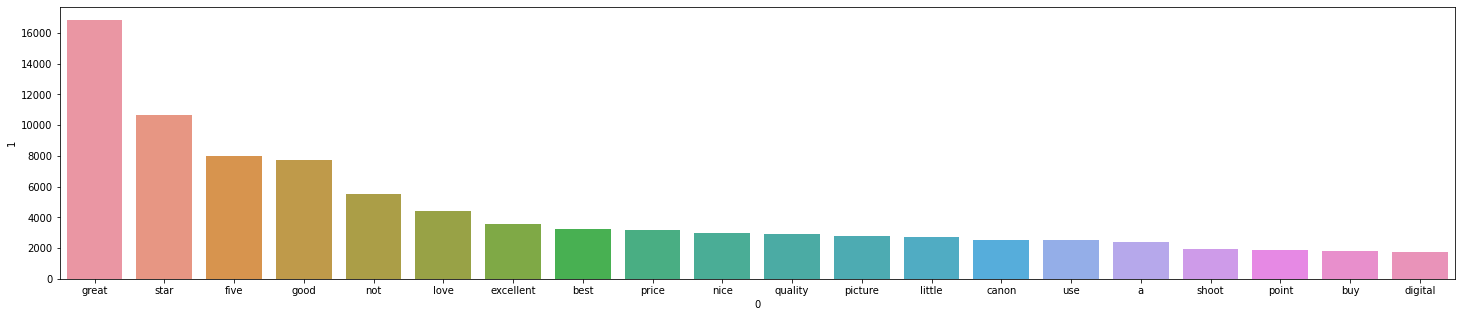

In [ ]:
# most common tokens summary

tokens = []
for x in data_df["summary"].tolist():
    for token in preprocess(x, sentences=False):
        tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

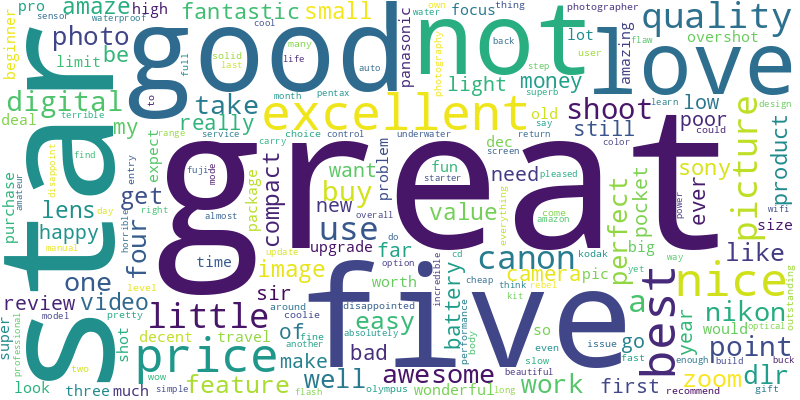

In [ ]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Text

In [ ]:
data_df["text"].head(10)

0    I bought the Smile to have a handy, inexpensiv...
1    It is absolutely useless.  The pictures are gr...
2    Bought one from Amazon and begun immediately t...
3    I'm on a small budget this summer, so I bought...
4    My first experiences with AGFA cameras were in...
5    I bought two of these for my kids and they are...
6    It's a nice little TOY.  That's all it is.  It...
7    I really like mine. It takes good pictures. It...
8    This is the best camera I have seen for the pr...
9    I have been in photography for about 15 years,...
Name: text, dtype: object

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


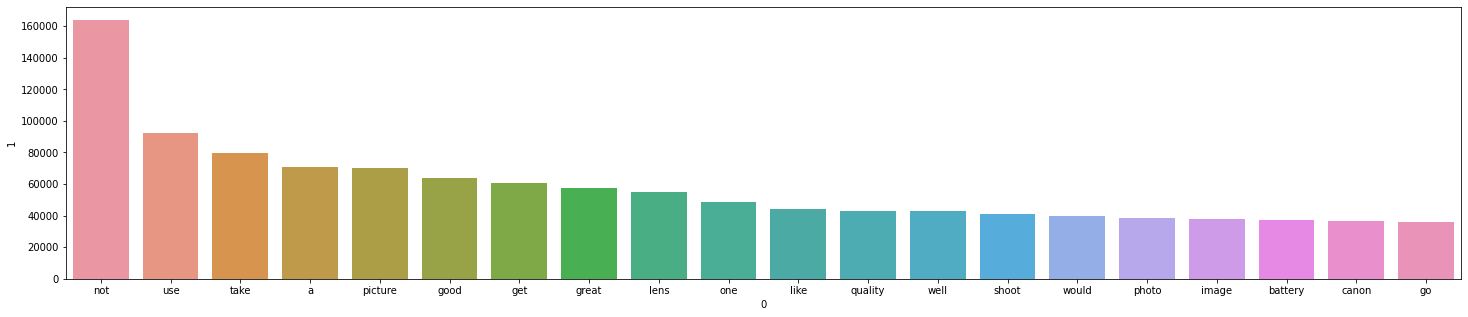

In [ ]:
# most common tokens text
tokens = []
for x in data_df["text"].tolist():
    for sentence in preprocess(x, sentences=True):
        for token in sentence:
            tokens.append(token)

data = pd.DataFrame(Counter(tokens).most_common(20))
_, ax = plt.subplots(figsize=(25, 5))
sns.barplot(data[0], data[1], ax=ax)

pass

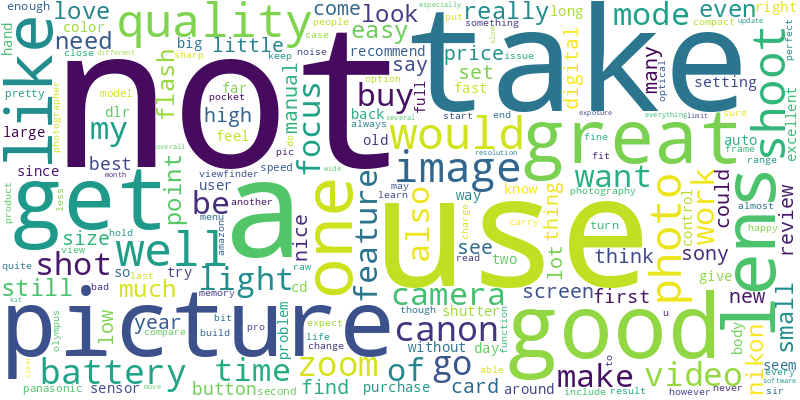

In [ ]:
c = Counter(tokens)
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()